In [401]:
# import machine learning and data science libarires
import math
import pandas as pd
import numpy as np

# import Google Finanace API libraries
from googlefinance.client import get_price_data

# import data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# import other libraries
import datetime as dt
import time

In [154]:
## set the benchmarl dates
#strt_date = '1995-01-01'
#end_date = '2015-06-18'

# set all the tickers
# choose between: 'AAPL', 'MSFT', AMZN'
my_ticker = 'AMZN'

# set all the parameters
my_params = {
'q': my_ticker,    #stock symbol (ex: "AAPL")
'i': "86400",      #interval size in seconds ("86400" = 1 day intervals)
'x': "INDEXNASD",  #stock exchange symbol on which stock is traded (ex: "NASD")
'p': "10Y"          #period (ex: "1Y" = 1 year)
}

# build the dataframe of the stock data
my_stck = get_price_data(my_params)

# reset the indexes
my_stck = my_stck.reset_index()

# print the head of my dataframe
print(my_stck.head())

                index   Open     High    Low    Close   Volume
0 2007-10-04 16:00:00  92.55  92.5700  91.45  92.2600  3320497
1 2007-10-05 16:00:00  93.55  93.7100  92.34  93.4300  5523452
2 2007-10-08 16:00:00  94.22  95.8500  94.00  95.8500  7432365
3 2007-10-09 16:00:00  96.59  96.7300  94.75  95.3237  7146385
4 2007-10-10 16:00:00  95.50  95.7483  94.37  94.6600  5574168


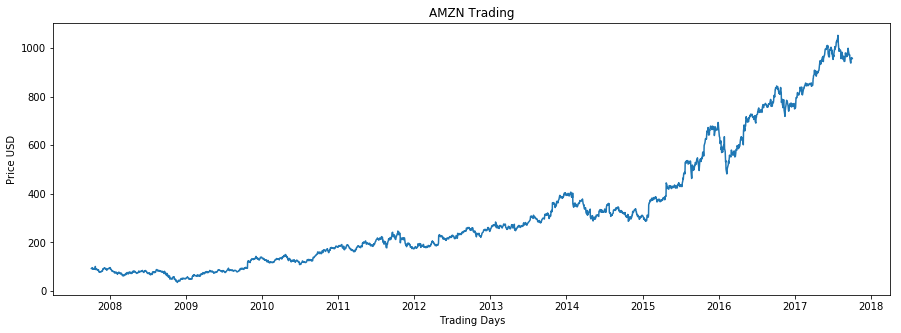

In [155]:
# plot data
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(my_stck['index'], my_stck['Close'])

# format the y-coord label
price = lambda y : '$%1.2f' % y
ax.format_ydata = price

# format the x-coord label
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title(my_ticker + ' Trading')

# add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

plt.show()

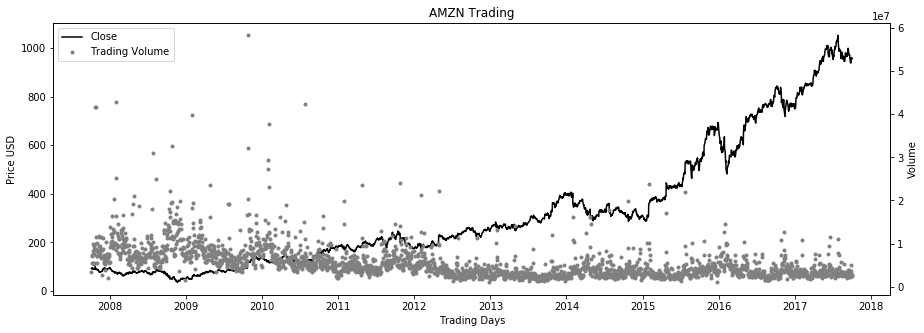

In [156]:
# plot data
fig, ax1 = plt.subplots(figsize=(15, 5))

# axis 1 - close prices vs. trading days
lns1 = ax1.plot(my_stck['index'], my_stck['Close'], 'black', label='Close')
#set x-axis label
ax1.set_xlabel('Trading Days')
# set y-axis label
ax1.set_ylabel('Price USD')

# axis 2 - volume vs. trading days
ax2 = ax1.twinx()
lns2 = ax2.plot(my_stck['index'], my_stck['Volume'], 'r.', color='gray', label='Trading Volume')
# set y-axis label
ax2.set_ylabel('Volume')

# add title
ax1.set_title(my_ticker + ' Trading')

# add legend
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

plt.show()

In [157]:
# create a new DataFrame with close change price and volume for observation of corelation
new_df = pd.DataFrame()

# time lag parameter in computing the close change price
t_lag = 1

# build the comparison comparison data from stock data
close_ys = my_stck['Close'][:-t_lag].reset_index()
close_td = my_stck['Close'][t_lag:].reset_index()
volume_td = my_stck['Volume'][t_lag:].reset_index()

# add factors to dataframe
new_df['Close_prcnt'] = (close_td['Close']-close_ys['Close'])/close_ys['Close']
new_df['Volume'] = volume_td['Volume']

print(new_df.head())

   Close_prcnt   Volume
0     0.012682  5523452
1     0.025902  7432365
2    -0.005491  7146385
3    -0.006963  5574168
4    -0.056201  9823727


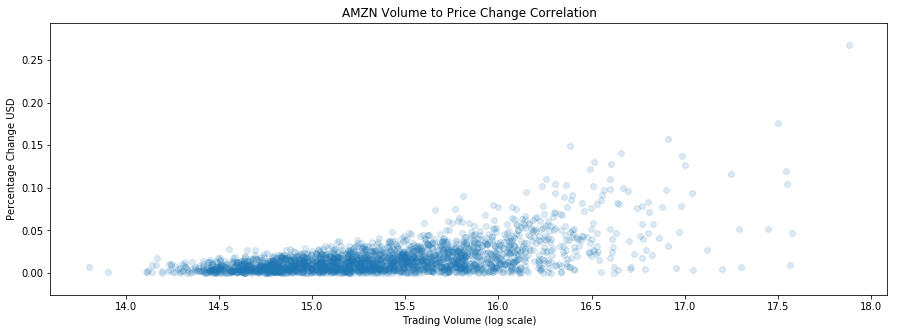

In [158]:
# scale the volume data with log
plot_vol = np.log(new_df['Volume'])
# absolute value of the close price change
plot_prcnt = np.abs(new_df['Close_prcnt'])

# plot Volume to Value Delta 
fig, ax = plt.subplots(figsize=(15, 5))
# axis 1 - adjusted Close
ax.scatter(plot_vol, plot_prcnt, alpha=0.15)

# set x-axis label
ax.set_xlabel('Trading Volume (log scale)')
# set y-axis label
ax.set_ylabel('Percentage Change USD')

# add title
ax.set_title(my_ticker + ' Volume to Price Change Correlation')

plt.show()

In [228]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

# Fix random seed for reproducibility
np.random.seed(7)
#plt.rcParams['figure.figsize'] = (18, 12)

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.metrics import mean_squared_error

# Import required libraries for visualization and printing
from pprint import pprint

In [332]:
# extract the two 'Close' and 'Date' columns for our studeis
#my_stck_date = my_stck.as_matrix(columns=[my_stck.columns[0]])
my_stck_close = my_stck.as_matrix(columns=[my_stck.columns[-2]])

In [461]:
def perpare_dataset(data, look_back=1, prcnt_split=0.7, normalize=True):
    '''
    cmt
    cmt
    cmt
    '''
    
    # find the index for splittig the data to training and test
    index_split = round(prcnt_split*len(data))
    
    # initialize the input training and test lists
    x_train_list = []
    x_test_list = []
    
    # build the training and test input lists based on the lookback parameter
    for i in range(look_back):
        x_train_list.append(data[i:index_split-look_back+1+i])
        x_test_list.append(data[index_split+1+i:len(data)-look_back+1+i])
        
    # do the same for output training and test data lists
    y_train_list = data[look_back:index_split+1]
    y_test_list = data[index_split+look_back:]
    
    # NORMALIZATION if needed...
    if normalize:
        
        scale_x_train = []
        scale_x_test = []
        
        for i in range(look_back):
            
            # assess the minimum and maximum for each column of input
            min_train, max_train = min(x_train_list[i]), max(x_train_list[i])
            min_test, max_test = min(x_test_list[i]), max(x_test_list[i])
            
            # store the values for future use -> scale back to USD price
            scale_x_train.append([min_train, max_train])
            scale_x_test.append([min_test, max_test])
            
            # perform the scaling on each column/feature
            x_train_list[i] = (x_train_list[i]-min_train)/(max_train-min_train)
            x_test_list[i] = (x_test_list[i]-min_test)/(max_test-min_test)
        
        # same for output data (see above)
        scale_y_train = [min(y_train_list), max(y_train_list)]
        scale_y_test = [min(y_test_list), max(y_test_list)]
        
        # same for output data (see above)
        y_train_list = (y_train_list-min(y_train_list))/(max(y_train_list)-min(y_train_list))
        y_test_list = (y_test_list-min(y_test_list))/(max(y_test_list)-min(y_test_list))
    
    # change the format of all lists to numpy arrays
    x_train = np.array(x_train_list).transpose()
    y_train = np.array(y_train_list)
    x_test = np.array(x_test_list).transpose()
    y_test = np.array(y_test_list)
    
    # return the prepared arrays
    return x_train, y_train, x_test, y_test

In [468]:
# reshape the dataset and prepare them for Keras
look_back = 1
prcnt_split = 0.7
normalize=True
x_train, y_train, x_test, y_test = perpare_dataset(my_stck_close, look_back, prcnt_split, normalize)

#from pprint import pprint
#pprint(y_train)

array([[ 0.15698081],
       [ 0.16348583],
       [ 0.16207113],
       ..., 
       [ 0.76173324],
       [ 0.7733724 ],
       [ 0.77192086]])


In [469]:
# create Keras Model
# set up hyperparameters
batch_size = 1
epochs = 1 # 200
n_nodes = [128]

# Create the LSTM model
model = Sequential()
model.add(LSTM(n_nodes[0], batch_input_shape=(batch_size, look_back, 1)))
model.add(Dense(1))
model.add(Activation('linear'))

# Compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ' + str(time.time() - start))

compilation time : 0.023379802703857422


In [471]:
# Train the model
model.fit(x_train, 
          y_train,
          nb_epoch=epochs, 
          batch_size=batch_size, 
          verbose=2)

ValueError: Error when checking input: expected lstm_9_input to have shape (1, 1, 1) but got array with shape (1, 1762, 1)

In [451]:
# Generate predictions for training
testPredict = model.predict(X_close_test, batch_size=batch_size)
#testPredict = util.predict_sequences(model, X_close_test)
pprint(testPredict)

NameError: name 'X_close_test' is not defined

NameError: name 'y_close_test' is not defined

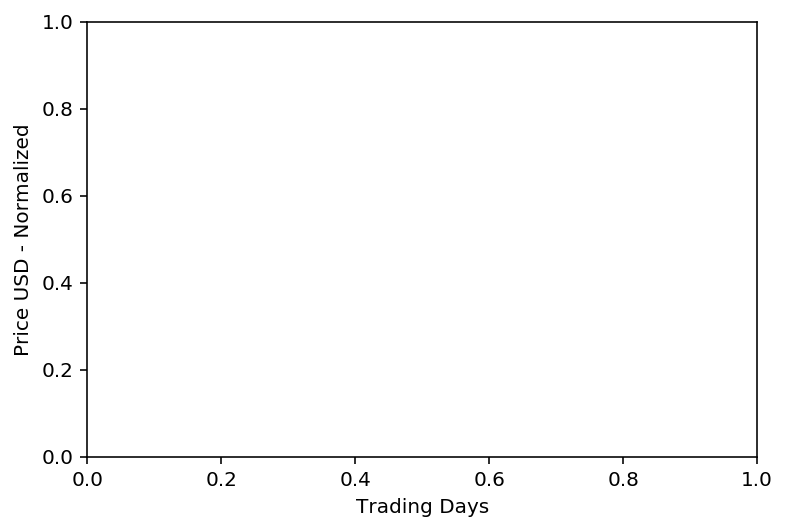

In [452]:
# Plot the predictions

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(y_close_test,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredict, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [453]:
# The mean squared error
testScore = model.evaluate(X_close_test, y_close_test, batch_size=batch_size, verbose=0)
print('Test Score: %.6f MSE (%.6f RMSE)' % (testScore, math.sqrt(testScore)))

NameError: name 'X_close_test' is not defined

In [ ]:
# Plot the predictions
close_plot = close_all[-y_close_test.shape[0]:]

pred_seq = np.array(testPredict)
#pprint(pred_seq)
preds_seq_plot, r = util.scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)
#pprint(preds_seq_plot)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')